In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5g-nidd-dataset/Combined.csv


In [17]:
# import shutil

# input_path = '/kaggle/input/5g-nidd-dataset'
# output_path = '/kaggle/temp/5g-nidd-dataset'
# # Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [18]:
cd /kaggle/temp/5g-nidd-dataset

/kaggle/temp/5g-nidd-dataset


In [19]:
!pip install fancyimpute
!pip install torch
!pip install scipy
!pip install --upgrade scikit-learn

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io
import missingno as msno
import multiprocessing
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F

In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import fancyimpute
from fancyimpute import IterativeImputer

In [22]:
df = pd.read_csv('Combined.csv', low_memory=False)
df.head()

,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign


In [23]:
print(df.shape)

(1215890, 52)


In [24]:
pd.set_option('float_format', '{:f}'.format)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["xtick.labelsize"] = 7
pd.set_option('future.no_silent_downcasting', True)

In [25]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Torch 2.1.2 CUDA 12.1
Device: cuda:0


In [27]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.01

num_classes = df['Attack Type'].nunique()
num_classes

9

In [28]:
# Segregate features and labels into separate variables
X, y = df.iloc[:, :-2].values, df.iloc[:, [-2]].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.01)

X_train = pd.DataFrame(X_train, columns=df.columns.to_list()[:-2])
X_test = pd.DataFrame(X_test, columns=df.columns.to_list()[:-2])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1203731, 50)
Testing dataset size: (12159, 50)
Training target size: (1203731, 1)
Testing target size: (12159, 1)


In [29]:
# Define a function to impute NaN values with the most frequent value in the group
def impute_most_frequent(group):
    mode_value = group.mode().iloc[0] if not group.mode().empty else np.nan
    return group.fillna(mode_value)

def handle_missing_values(df):
    df.drop_duplicates(inplace=True)
    df.drop(['sVid', 'dVid'], axis=1, inplace=True)
    df.dropna(subset=['sTos', 'sHops', 'sTtl', 'sDSb'], how='any', inplace=True)
    df[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']] = df.groupby('Attack Type')[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']].transform(impute_most_frequent)
    df['dDSb'] = df['dDSb'].fillna('cs0')
    
    df_subset_copy = df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']].copy(deep=True)
    mice_imputer = IterativeImputer()
    df_subset_copy.iloc[:, :] = mice_imputer.fit_transform(df_subset_copy)
    df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']] = df_subset_copy

In [30]:
train_df = pd.concat([X_train, y_train], axis='columns')
handle_missing_values(train_df)
print(train_df.shape)
train_df.isna().any()

(1203516, 49)


Unnamed: 0     False
Seq            False
Dur            False
RunTime        False
Mean           False
Sum            False
Min            False
Max            False
Proto          False
sTos           False
dTos           False
sDSb           False
dDSb           False
sTtl           False
dTtl           False
sHops          False
dHops          False
Cause          False
TotPkts        False
SrcPkts        False
DstPkts        False
TotBytes       False
SrcBytes       False
DstBytes       False
Offset         False
sMeanPktSz     False
dMeanPktSz     False
Load           False
SrcLoad        False
DstLoad        False
Loss           False
SrcLoss        False
DstLoss        False
pLoss          False
SrcGap         False
DstGap         False
Rate           False
SrcRate        False
DstRate        False
State          False
SrcWin         False
DstWin         False
SrcTCPBase     False
DstTCPBase     False
TcpRtt         False
SynAck         False
AckDat         False
Label        

In [31]:
X_train, y_train = train_df.loc[:, train_df.columns != 'Attack Type'], train_df['Attack Type']
print("Training dataset size:", X_train.shape)
print("Training target size:", y_train.shape)

Training dataset size: (1203516, 48)
Training target size: (1203516,)


In [32]:
def one_hot_encode(df):
    proto_dummies = pd.get_dummies(df.Proto, dtype=int, prefix='Proto')
    proto_dummies.drop(columns=['Proto_ipv6-icmp'], inplace=True)
    sDSb_dummies = pd.get_dummies(df.sDSb, dtype=int, prefix='sDSb')
    sDSb_dummies.drop(columns=['sDSb_39','sDSb_54', 'sDSb_4', 'sDSb_cs4'], inplace=True)
    dDSb_dummies = pd.get_dummies(df.dDSb, dtype=int, prefix='dDSb')
    dDSb_dummies.drop(columns=['dDSb_cs4'], inplace=True)
    Cause_dummies = pd.get_dummies(df.Cause, dtype=int, prefix='Cause')
    Cause_dummies.drop(columns=['Cause_Shutdown'], inplace=True)
    State_dummies = pd.get_dummies(df.State, dtype=int, prefix='State')
    State_dummies.drop(columns=['State_RSP','State_TST','State_NRS'], inplace=True)
    df = pd.concat([df, proto_dummies, sDSb_dummies, dDSb_dummies, Cause_dummies, State_dummies], axis='columns')
    df.drop(columns=['Proto', 'sDSb', 'dDSb', 'Cause', 'State', 'Label', 'Unnamed: 0', 'Seq', 'RunTime', 'Mean', 'Sum', 'Min', 'Max'], inplace=True)
    return df

In [33]:
X_train = one_hot_encode(X_train)

In [34]:
print(X_train.head())
X_train.columns

       Dur     sTos     dTos      sTtl      dTtl    sHops    dHops TotPkts  \
0 0.000000 0.000000 0.000000 63.000000 64.000000 1.000000 0.000000       1   
1 0.000000 0.000000 0.949951 63.000000 64.096707 1.000000 2.185725       1   
2 2.583721 0.000000 0.949951 63.000000 64.096707 1.000000 2.185725       2   
3 0.034361 0.000000 0.000000 63.000000 59.000000 1.000000 5.000000       7   
4 4.547992 0.000000 0.949951 63.000000 64.096707 1.000000 2.185725       2   

  SrcPkts DstPkts  ... Cause_Start Cause_Status State_ACC State_CON State_ECO  \
0       1       0  ...           0            1         0         0         0   
1       1       0  ...           1            0         0         0         0   
2       2       0  ...           0            1         0         0         0   
3       4       3  ...           1            0         0         1         0   
4       2       0  ...           1            0         0         0         0   

  State_FIN State_INT State_REQ State_RST St

Index(['Dur', 'sTos', 'dTos', 'sTtl', 'dTtl', 'sHops', 'dHops', 'TotPkts',
       'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset',
       'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss',
       'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate',
       'DstRate', 'SrcWin', 'DstWin', 'SrcTCPBase', 'DstTCPBase', 'TcpRtt',
       'SynAck', 'AckDat', 'Proto_icmp', 'Proto_sctp', 'Proto_tcp',
       'Proto_udp', 'sDSb_52', 'sDSb_af11', 'sDSb_af12', 'sDSb_af41',
       'sDSb_cs0', 'sDSb_cs6', 'sDSb_cs7', 'sDSb_ef', 'dDSb_af11', 'dDSb_af12',
       'dDSb_cs0', 'dDSb_cs1', 'dDSb_ef', 'Cause_Start', 'Cause_Status',
       'State_ACC', 'State_CON', 'State_ECO', 'State_FIN', 'State_INT',
       'State_REQ', 'State_RST', 'State_URP'],
      dtype='object')

In [35]:
def normalize_dataframe(df):
    std_scaler = preprocessing.StandardScaler()
    std_normalized = std_scaler.fit_transform(df)
    df = pd.DataFrame(std_normalized, columns = df.columns)
    return df

In [36]:
X_train = normalize_dataframe(X_train)
X_train.head()

,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
0,-0.807007,-0.069049,-0.094771,-0.330093,-0.007236,-0.352786,-0.973032,-0.166854,-0.146671,-0.115594,...,-0.816856,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384
1,-0.807007,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.166854,-0.146671,-0.115594,...,1.224205,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384
2,0.720610,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,-0.816856,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384
3,-0.786692,-0.069049,-0.094771,-0.330093,-0.381365,-0.352786,1.252848,0.074627,0.016258,0.124372,...,1.224205,-1.222728,-0.030274,2.863662,-0.155785,-0.226143,-0.608858,-0.969660,-0.257690,-0.025384
4,1.881979,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,1.224205,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384


In [39]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [40]:
train_df = pd.concat([X_train, y_train], axis='columns')
print(train_df.shape)
train_df.head()

(1203731, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807007,-0.069049,-0.094771,-0.330093,-0.007236,-0.352786,-0.973032,-0.166854,-0.146671,-0.115594,...,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384,Benign
1,-0.807007,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.166854,-0.146671,-0.115594,...,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384,UDPFlood
2,0.720610,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384,UDPFlood
3,-0.786692,-0.069049,-0.094771,-0.330093,-0.381365,-0.352786,1.252848,0.074627,0.016258,0.124372,...,-1.222728,-0.030274,2.863662,-0.155785,-0.226143,-0.608858,-0.969660,-0.257690,-0.025384,SlowrateDoS
4,1.881979,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384,UDPFlood


In [41]:
from sklearn.preprocessing import OrdinalEncoder

# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
y_train = encoder.fit_transform(y_train.iloc[:].values.reshape(-1, 1))
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_train['Attack Type'] = pd.to_numeric(y_train['Attack Type'], downcast='integer')
y_train.head()

,Attack Type
0,0
1,7
2,7
3,5
4,7


In [42]:
train_df.head()

,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807007,-0.069049,-0.094771,-0.330093,-0.007236,-0.352786,-0.973032,-0.166854,-0.146671,-0.115594,...,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384,Benign
1,-0.807007,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.166854,-0.146671,-0.115594,...,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384,UDPFlood
2,0.720610,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,0.817844,-0.030274,-0.349203,-0.155785,-0.226143,-0.608858,1.031289,-0.257690,-0.025384,UDPFlood
3,-0.786692,-0.069049,-0.094771,-0.330093,-0.381365,-0.352786,1.252848,0.074627,0.016258,0.124372,...,-1.222728,-0.030274,2.863662,-0.155785,-0.226143,-0.608858,-0.969660,-0.257690,-0.025384,SlowrateDoS
4,1.881979,-0.069049,0.000000,-0.330093,0.000000,-0.352786,0.000000,-0.126607,-0.092361,-0.115594,...,-1.222728,-0.030274,-0.349203,-0.155785,-0.226143,1.642419,-0.969660,-0.257690,-0.025384,UDPFlood


In [43]:
# obtain training indices that will be used for validation
num_train = len(X_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [44]:
print('Training set size:', num_train - split)
print('Validation set size:', split)
print('Testing set size:', len(X_test))

Training set size: 1191481
Validation set size: 12035
Testing set size: 12159


In [45]:
# Example usage
train_data = {'features': X_train,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_train}     # Your label data

dataset = CustomTabularDataset(train_data)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size,
#     num_workers=num_workers)

In [54]:
# Creating a PyTorch class
# 62 ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 62 ===> 8
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(62, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh(),  
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 8 ==> 62
#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(8, 16),
#             torch.nn.ReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.ReLU(),
#             torch.nn.Linear(32, 62),
#             torch.nn.Sigmoid()
#         )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 8 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, 64),  # Input size is 8 from the encoder
            torch.nn.BatchNorm1d(64),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),              
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
        output = self.dense_nn(encoded)
        return output

In [55]:
# Model Initialization
model = Autoencoder()

# Validation using MSE Loss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)


In [56]:
# number of epochs to train the model
n_epochs = 8

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

# Moving model tensor to GPU if available
model = model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for data, target in tqdm(train_loader):        

        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())    
        
        # Moving output tensor to GPU if available
        output = output.to(device)

        # calculate the batch loss
        loss = loss_function(output, target.reshape(-1).long())
        
        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_train_samples += target.size(0)
#         print(total_train_correct)
#         print(total_train_samples)
#         print((predicted == target).sum().item())
#         print('---------------')


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        output = output.to(device)
        
        # calculate the loss
        loss = loss_function(output, target.reshape(-1).long())        
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_valid_samples += target.size(0)


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 189/189 [00:00<00:00, 197.22it/s]


Epoch: 1 	Training Loss: 1.385485 	Validation Loss: 1.376494
Epoch: 1 	Training Accuracy: 98.897003 	Validation Accuracy: 99.543000
Training loss decreased (inf --> 1.385485).
Validation loss decreased (inf --> 1.376494).  Saving model ...


100%|██████████| 189/189 [00:00<00:00, 199.05it/s]


Epoch: 2 	Training Loss: 1.377803 	Validation Loss: 1.376628
Epoch: 2 	Training Accuracy: 99.420553 	Validation Accuracy: 99.526381


100%|██████████| 189/189 [00:00<00:00, 206.36it/s]


Epoch: 3 	Training Loss: 1.376976 	Validation Loss: 1.375641
Epoch: 3 	Training Accuracy: 99.502300 	Validation Accuracy: 99.626091
Training loss decreased (1.385485 --> 1.376976).
Validation loss decreased (1.376494 --> 1.375641).  Saving model ...


100%|██████████| 189/189 [00:00<00:00, 198.78it/s]


Epoch: 4 	Training Loss: 1.376719 	Validation Loss: 1.375260
Epoch: 4 	Training Accuracy: 99.526388 	Validation Accuracy: 99.667636
Training loss decreased (1.376976 --> 1.376719).
Validation loss decreased (1.375641 --> 1.375260).  Saving model ...


100%|██████████| 189/189 [00:00<00:00, 208.31it/s]


Epoch: 5 	Training Loss: 1.376591 	Validation Loss: 1.376156
Epoch: 5 	Training Accuracy: 99.537634 	Validation Accuracy: 99.576236


100%|██████████| 189/189 [00:00<00:00, 194.76it/s]


Epoch: 6 	Training Loss: 1.376226 	Validation Loss: 1.375209
Epoch: 6 	Training Accuracy: 99.573724 	Validation Accuracy: 99.675945
Training loss decreased (1.376719 --> 1.376226).
Validation loss decreased (1.375260 --> 1.375209).  Saving model ...


100%|██████████| 189/189 [00:00<00:00, 192.62it/s]


Epoch: 7 	Training Loss: 1.376388 	Validation Loss: 1.375589
Epoch: 7 	Training Accuracy: 99.556938 	Validation Accuracy: 99.634400


100%|██████████| 189/189 [00:00<00:00, 197.79it/s]

Epoch: 8 	Training Loss: 1.376507 	Validation Loss: 1.376002
Epoch: 8 	Training Accuracy: 99.545859 	Validation Accuracy: 99.592854


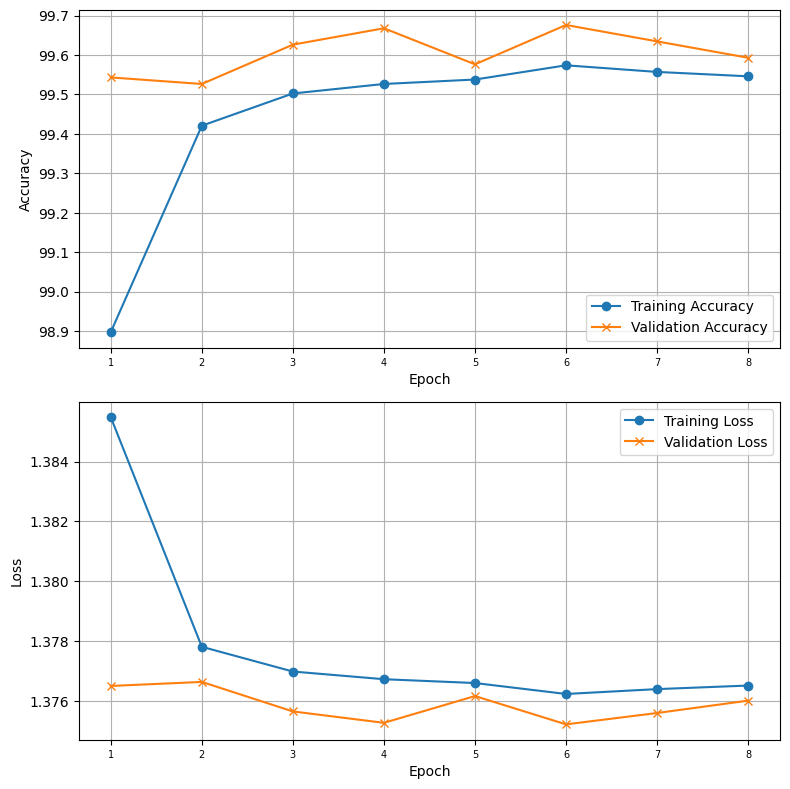

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()